In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

In [26]:
df = pd.read_csv('uncleaned_final_final.csv')
df

,Unnamed: 0,Normalized EBITDA,Reconciled Depreciation,EBITDA,EBIT,Interest Expense,Diluted Average Shares,Diluted EPS,Net Income,Tax Provision,Other Non Operating Income Expenses,Operating Income,Operating Expense,Other Operating Expenses,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue,Ticker,Sector
0,2025-06-30,2.160000e+09,1.140000e+09,2.160000e+09,1.020000e+09,600000000.0,3.613445e+08,1.19,4.300000e+08,-2.000000e+07,4.000000e+07,8.100000e+08,4.720000e+09,2.490000e+09,5.530000e+09,1.122000e+10,1.675000e+10,1.675000e+10,AARTIIND.NS,Chemicals
1,2025-03-31,2.374600e+09,1.132700e+09,2.268000e+09,1.135300e+09,253000000.0,NaN,NaN,9.587000e+08,-7.630000e+07,-3.318000e+08,1.868400e+09,-3.518700e+09,3.300000e+09,-1.650300e+09,1.973350e+10,1.808320e+10,1.808320e+10,AARTIIND.NS,Chemicals
2,2024-12-31,2.360000e+09,1.110000e+09,2.360000e+09,1.250000e+09,850000000.0,3.622047e+08,1.27,4.600000e+08,-6.000000e+07,5.000000e+07,1.210000e+09,4.890000e+09,2.730000e+09,6.100000e+09,1.230000e+10,1.840000e+10,1.840000e+10,AARTIIND.NS,Chemicals
3,2024-09-30,2.020000e+09,1.080000e+09,2.040000e+09,9.600000e+08,620000000.0,3.611111e+08,1.44,5.200000e+08,-1.800000e+08,5.000000e+07,8.800000e+08,5.230000e+09,3.100000e+09,6.110000e+09,1.017000e+10,1.628000e+10,1.628000e+10,AARTIIND.NS,Chemicals
4,2024-06-30,3.110000e+09,1.020000e+09,3.110000e+09,2.090000e+09,640000000.0,3.633952e+08,3.77,1.370000e+09,8.000000e+07,6.000000e+07,1.980000e+09,4.960000e+09,2.740000e+09,6.940000e+09,1.157000e+10,1.851000e+10,1.851000e+10,AARTIIND.NS,Chemicals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,2025-06-30,2.243400e+10,2.381000e+09,2.243400e+10,2.005300e+10,847000000.0,1.006036e+09,14.58,1.466800e+10,4.340000e+09,1.549000e+09,1.793300e+10,2.884200e+10,1.747600e+10,4.677500e+10,1.789500e+10,6.467000e+10,6.467000e+10,ZYDUSLIFE.NS,Healthcare
1504,2025-03-31,1.990900e+10,2.379000e+09,1.914100e+10,1.676200e+10,42000000.0,NaN,NaN,1.170900e+10,4.232000e+09,-1.800000e+09,1.927000e+10,2.337700e+10,-1.879200e+10,4.264700e+10,2.025500e+10,6.290200e+10,6.290200e+10,ZYDUSLIFE.NS,Healthcare
1505,2024-12-31,1.445100e+10,2.290000e+09,1.445100e+10,1.216100e+10,320000000.0,1.006391e+09,10.17,1.023500e+10,1.795000e+09,5.750000e+08,9.760000e+09,2.564100e+10,1.534200e+10,3.540100e+10,1.583400e+10,5.123500e+10,5.123500e+10,ZYDUSLIFE.NS,Healthcare
1506,2024-09-30,1.529600e+10,2.336000e+09,1.529600e+10,1.296000e+10,251000000.0,1.005740e+09,9.06,9.112000e+09,3.731000e+09,6.820000e+08,1.182400e+10,2.459800e+10,1.470400e+10,3.642200e+10,1.471400e+10,5.113600e+10,5.113600e+10,ZYDUSLIFE.NS,Healthcare


In [27]:
important_cols = [
    "Total Revenue",
    "Operating Revenue",
    "Gross Profit",
    "EBITDA",
    "EBIT",
    "Operating Income",
    "Net Income",
    "Operating Expense",
    "Cost Of Revenue",
    "Diluted EPS"
]

def corrupted_or_missing(x):
    """
    Returns True if column for this ticker is completely unusable:
    - All values NaN
    - All values 0 (or a single repeated constant)
    """
    return x.isna().all() or (x.nunique(dropna=True) == 1 and (x.iloc[0] in [0, -9999]))

# Apply check ticker-wise
mask = df.groupby("Ticker").apply(
    lambda g: g.apply(corrupted_or_missing)
).any(axis=1)

# Tickers to drop
tickers_to_drop = mask[mask].index.tolist()

print(len(tickers_to_drop))

# Cleaned dataframe
df = df[~df["Ticker"].isin(tickers_to_drop)]

63


C:\Users\mjaye\AppData\Local\Temp\ipykernel_8908\3039813572.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mask = df.groupby("Ticker").apply(


In [28]:
# Filter the DataFrame to only include rows where 'Sector' is not null
df = df[df['Sector'].notna()]

In [29]:
def impute_financials(df, group_key="Ticker"):
    df_out = df.copy()
    
    # interpolate within each ticker
    df_out = df_out.groupby(group_key).apply(
        lambda g: g.interpolate(method="linear", limit_direction="both")
    ).reset_index(drop=True)
    
    # fill remaining NaN with sector/overall median
    df_out = df_out.fillna(df_out.median(numeric_only=True))
    
    return df_out

In [30]:
df = impute_financials(df)

C:\Users\mjaye\AppData\Local\Temp\ipykernel_8908\527018751.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  lambda g: g.interpolate(method="linear", limit_direction="both")
C:\Users\mjaye\AppData\Local\Temp\ipykernel_8908\527018751.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  lambda g: g.interpolate(method="linear", limit_direction="both")
C:\Users\mjaye\AppData\Local\Temp\ipykernel_8908\527018751.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  lambda g: g.interpolate(method="linear", limit_direction="both")
C:\Users\mjaye\AppData\Local\Temp\ipykernel_8908\527018751.py:6: FutureWarning: DataFrame.inte

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1194 entries, 0 to 1193
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           1194 non-null   object 
 1   Normalized EBITDA                    1194 non-null   float64
 2   Reconciled Depreciation              1194 non-null   float64
 3   EBITDA                               1194 non-null   float64
 4   EBIT                                 1194 non-null   float64
 5   Interest Expense                     1194 non-null   float64
 6   Diluted Average Shares               1194 non-null   float64
 7   Diluted EPS                          1194 non-null   float64
 8   Net Income                           1194 non-null   float64
 9   Tax Provision                        1194 non-null   float64
 10  Other Non Operating Income Expenses  1194 non-null   float64
 11  Operating Income              

In [32]:
import pandas as pd

# Convert to datetime
df["Unnamed: 0"] = pd.to_datetime(df["Unnamed: 0"], errors="coerce")

# (Optional) rename it for clarity
df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)

In [33]:
df = df.sort_values(by=["Ticker", "Date"]).reset_index(drop=True)

In [34]:
# Total unique quarters in dataset
print("Unique quarters in dataset:", df["Date"].nunique())

# Count how many unique quarters per ticker
quarter_counts = df.groupby("Ticker")["Date"].nunique()

# Summary stats
print(quarter_counts.describe())

# Tickers with < 5 quarters (incomplete data)
missing_quarters = quarter_counts[quarter_counts < 5]
print("Tickers with missing quarters:\n", missing_quarters)

# Split into mildly vs heavily corrupted
missing_one = quarter_counts[quarter_counts == 4]
heavily_corrupted = quarter_counts[quarter_counts <= 3]

print("\nTickers missing exactly 1 quarter:\n", missing_one)
print("\nHeavily corrupted tickers:\n", heavily_corrupted)


Unique quarters in dataset: 5
count    239.000000
mean       4.995816
std        0.064685
min        4.000000
25%        5.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Date, dtype: float64
Tickers with missing quarters:
 Ticker
PGHH.NS    4
Name: Date, dtype: int64

Tickers missing exactly 1 quarter:
 Ticker
PGHH.NS    4
Name: Date, dtype: int64

Heavily corrupted tickers:
 Series([], Name: Date, dtype: int64)


In [35]:
df = df[df["Ticker"] != "PGHH.NS"]

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assume 'df' is your pre-loaded DataFrame

# --- STEP 1: (NEW) FEATURE ENGINEERING ---
# Create more powerful features from your existing data.
# This step is crucial for model performance.
# Add or remove ratios based on the columns you have.
# --- FEATURE ENGINEERING SECTION ---
# We use .replace(0, np.nan) to avoid division-by-zero errors, then fill any resulting NaNs.

print("Starting feature engineering...")

# 1. Profitability Ratios (How well the company generates profit)
df['Gross_Profit_Margin'] = (df['Gross Profit'] / df['Total Revenue'].replace(0, np.nan)).fillna(0)
df['Operating_Margin'] = (df['Operating Income'] / df['Total Revenue'].replace(0, np.nan)).fillna(0)
df['Net_Profit_Margin'] = (df['Net Income'] / df['Total Revenue'].replace(0, np.nan)).fillna(0)
df['EBITDA_Margin'] = (df['Normalized EBITDA'] / df['Total Revenue'].replace(0, np.nan)).fillna(0)

# 2. Operational Efficiency Ratios (How well the company manages costs)
df['Expense_Ratio'] = (df['Operating Expense'] / df['Total Revenue'].replace(0, np.nan)).fillna(0)
# Calculate Pretax Income to find the effective tax rate
pretax_income = df['Net Income'] + df['Tax Provision']
df['Effective_Tax_Rate'] = (df['Tax Provision'] / pretax_income.replace(0, np.nan)).fillna(0)

# 3. Growth Metrics (Quarter-over-Quarter changes)
# This is critical for a time-series model. It calculates the % change from the previous quarter.
df = df.sort_values(by=['Ticker', 'Date']) # Make sure data is sorted correctly
df['Revenue_Growth_QoQ'] = df.groupby('Ticker')['Total Revenue'].pct_change().fillna(0)
df['Net_Income_Growth_QoQ'] = df.groupby('Ticker')['Net Income'].pct_change().fillna(0)
df['Gross_Profit_Growth_QoQ'] = df.groupby('Ticker')['Gross Profit'].pct_change().fillna(0)



# Clean up infinite values that might result from pct_change if a previous value was 0
df.replace([np.inf, -np.inf], 0, inplace=True)

df.to_csv('final_engineered.csv', index=False)

print("Feature engineering complete. New columns added.")
# --- END OF FEATURE ENGINEERING ---

Starting feature engineering...
Feature engineering complete. New columns added.


In [37]:
df = pd.read_csv('final_engineered.csv')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Date                                 1190 non-null   object 
 1   Normalized EBITDA                    1190 non-null   float64
 2   Reconciled Depreciation              1190 non-null   float64
 3   EBITDA                               1190 non-null   float64
 4   EBIT                                 1190 non-null   float64
 5   Interest Expense                     1190 non-null   float64
 6   Diluted Average Shares               1190 non-null   float64
 7   Diluted EPS                          1190 non-null   float64
 8   Net Income                           1190 non-null   float64
 9   Tax Provision                        1190 non-null   float64
 10  Other Non Operating Income Expenses  1190 non-null   float64
 11  Operating Income              

In [65]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

df = pd.read_csv('final_engineered.csv')

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date'])

# Define feature and target columns
target_col = 'Net Income'
# Select all numeric columns as features, excluding the target and identifiers
feature_cols = df.select_dtypes(include=np.number).columns.drop(target_col)

print(f"Target Column: {target_col}")
print(f"Number of Feature Columns: {len(feature_cols)}")

Target Column: Net Income
Number of Feature Columns: 25


In [66]:
X, y = [], []
n_past = 4 # Use the past 4 rows (quarters) to predict the 5th

# Group by each company's ticker to create sequences
for ticker, group in df.groupby('Ticker'):
    features = group[feature_cols].values
    target = group[target_col].values
    
    # Ensure there's enough data for at least one window
    if len(group) > n_past:
        for i in range(n_past, len(group)):
            # The past 4 rows of features
            X.append(features[i-n_past:i, :])
            # The 'Net Income' of the current row (the one we want to predict)
            y.append(target[i])

X = np.array(X)
y = np.array(y)

print(f"\nOriginal X shape (Samples, Timesteps, Features): {X.shape}")
print(f"Original y shape (Samples,): {y.shape}")


Original X shape (Samples, Timesteps, Features): (238, 4, 25)
Original y shape (Samples,): (238,)


In [67]:
# Split data before scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. Log Transform the Target Variable (y) ---
# This handles skewness and allows the model to learn relative changes.
# We use a "signed log" to properly handle the negative Net Income values.
y_train_log = np.sign(y_train) * np.log1p(np.abs(y_train))
y_test_log = np.sign(y_test) * np.log1p(np.abs(y_test))

# --- 4. Scale the Data ---
# Scaler for features
scaler_X = MinMaxScaler()
n_train_samples, timesteps, n_features = X_train.shape
n_test_samples = X_test.shape[0]

# Reshape for scaling: (samples * timesteps, features)
X_train_reshaped = X_train.reshape(-1, n_features)
X_test_reshaped = X_test.reshape(-1, n_features)

# Fit on training data and transform both train and test
X_train_scaled_reshaped = scaler_X.fit_transform(X_train_reshaped)
X_test_scaled_reshaped = scaler_X.transform(X_test_reshaped)

# Reshape back to (samples, timesteps, features)
X_train_scaled = X_train_scaled_reshaped.reshape(n_train_samples, timesteps, n_features)
X_test_scaled = X_test_scaled_reshaped.reshape(n_test_samples, timesteps, n_features)

# Scaler for the target variable (y)
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

In [68]:
# This is the key step for the FCN approach
X_train_flat = X_train_scaled.reshape(n_train_samples, timesteps * n_features)
X_test_flat = X_test_scaled.reshape(n_test_samples, timesteps * n_features)

print(f"\nFlattened X_train shape for FCN input: {X_train_flat.shape}")
print(f"Flattened X_test shape for FCN input: {X_test_flat.shape}")


Flattened X_train shape for FCN input: (190, 100)
Flattened X_test shape for FCN input: (48, 100)


In [69]:
model = Sequential([
    # Input layer's shape is the number of flattened features
    Dense(128, activation='relu', input_shape=(timesteps * n_features,)),
    Dense(64, activation='relu'),
    # Final output layer has 1 neuron for the single regression target
    Dense(1) 
])

model.compile(optimizer='adam', loss='mse')
model.summary()

print("\n--- Training Model ---")
history = model.fit(
    X_train_flat, 
    y_train_scaled, 
    epochs=50, 
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


print("\n--- Evaluating Model ---")
loss = model.evaluate(X_test_flat, y_test_scaled, verbose=0)
print(f"Test Loss (MSE on scaled data): {loss:.4f}")

C:\Users\mjaye\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)


--- Training Model ---
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0078 - val_loss: 0.0046
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.1314e-04 - val_loss: 0.0013
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5728e-04 - val_loss: 8.9104e-04
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0550e-04 - val_loss: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0218e-04 - val_loss: 8.8403e-04
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.2093e-04 - val_loss: 8.9599e-04
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.9278e-04 - val_loss: 8.4001e-04
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8334e-04 - val_loss: 8.2360e-04
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0388e-04 - val_loss: 7.8390e-04
Epoch 1

In [71]:
# Make predictions
predictions_scaled = model.predict(X_test_flat)

predictions_actual = scaler_y.inverse_transform(predictions_scaled)
y_test_actual = scaler_y.inverse_transform(y_test_scaled)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [72]:
print(predictions_actual)
print(y_test_actual)

[[ 3.68970240e+09]
 [ 2.44894362e+09]
 [ 1.19449405e+10]
 [ 1.98742528e+09]
 [ 3.35346094e+10]
 [ 1.46393357e+09]
 [ 2.31046707e+09]
 [ 1.65868096e+09]
 [ 1.89918643e+09]
 [ 5.54051904e+08]
 [ 8.42552013e+09]
 [ 3.97783613e+10]
 [ 5.91749952e+08]
 [ 3.92300390e+09]
 [ 4.93117440e+10]
 [ 6.82344550e+09]
 [ 1.16746813e+10]
 [ 1.19124979e+09]
 [ 1.98897894e+09]
 [ 1.11234130e+10]
 [ 2.56338483e+09]
 [ 1.18079053e+09]
 [ 7.15332544e+08]
 [ 2.15010253e+09]
 [ 1.18833229e+09]
 [ 4.32180326e+09]
 [-1.58754368e+08]
 [ 1.74390426e+09]
 [ 1.66502336e+09]
 [ 2.18665882e+10]
 [ 1.82018163e+09]
 [ 1.37448576e+09]
 [ 9.20738496e+08]
 [ 9.65358285e+09]
 [ 3.52532813e+09]
 [ 2.55247872e+09]
 [ 1.02764435e+09]
 [ 1.75455398e+09]
 [ 6.21144704e+08]
 [ 2.44726144e+09]
 [ 2.05226317e+09]
 [ 1.94696128e+09]
 [ 4.92518912e+09]
 [ 4.64957491e+09]
 [ 2.61175828e+10]
 [ 4.82173389e+09]
 [ 1.22726861e+09]
 [ 1.47115738e+09]]
[[ 3.244200e+09]
 [ 2.371700e+09]
 [ 1.140600e+10]
 [ 1.324000e+09]
 [ 3.384860e+10]
 [

Mean Absolute Error (MAE): 1.389999e+09
Mean Squared Error (MSE): 7.110121e+18
Root Mean Squared Error (RMSE): 2.666481e+09


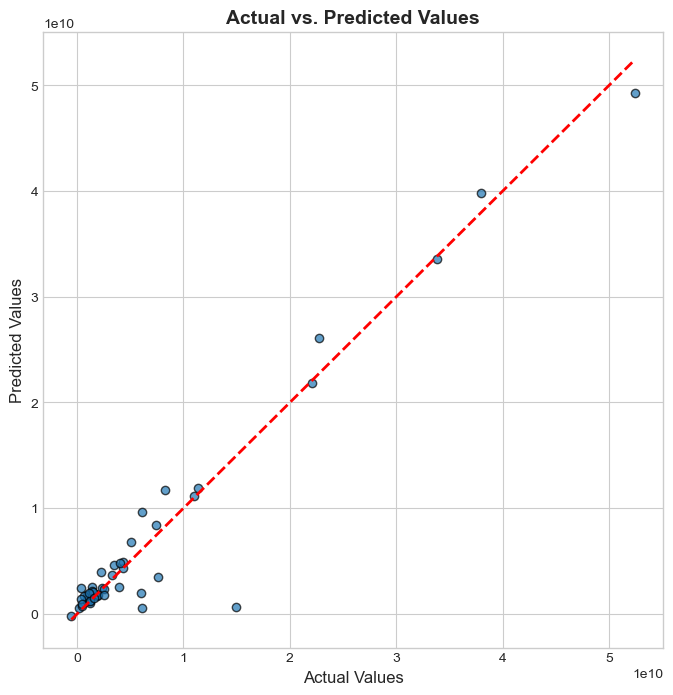

In [73]:
mae = mean_absolute_error(y_test_actual, predictions_actual)
mse = mean_squared_error(y_test_actual, predictions_actual)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:e}")
print(f"Mean Squared Error (MSE): {mse:e}")
print(f"Root Mean Squared Error (RMSE): {rmse:e}")


# Plotting
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test_actual, predictions_actual, alpha=0.7, edgecolors='k')
ax.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
ax.set_xlabel('Actual Values', fontsize=12)
ax.set_ylabel('Predicted Values', fontsize=12)
ax.set_title('Actual vs. Predicted Values', fontsize=14, fontweight='bold')
plt.show()

In [74]:
df.describe()

,Date,Normalized EBITDA,Reconciled Depreciation,EBITDA,EBIT,Interest Expense,Diluted Average Shares,Diluted EPS,Net Income,Tax Provision,...,Operating Revenue,Gross_Profit_Margin,Operating_Margin,Net_Profit_Margin,EBITDA_Margin,Expense_Ratio,Effective_Tax_Rate,Revenue_Growth_QoQ,Net_Income_Growth_QoQ,Gross_Profit_Growth_QoQ
count,1190,1.190000e+03,1.190000e+03,1.190000e+03,1.190000e+03,1.190000e+03,1.190000e+03,1190.000000,1.190000e+03,1.190000e+03,...,1.190000e+03,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000,1190.000000
mean,2024-12-30 00:00:00,1.059392e+10,2.303243e+09,1.071053e+10,8.416383e+09,1.280075e+09,9.791880e+08,19.685904,5.551494e+09,1.803624e+09,...,5.315591e+10,0.474135,0.144444,0.143405,0.245638,0.328962,0.253311,0.050888,0.246940,0.336219
min,2024-06-30 00:00:00,-6.560000e+09,1.450300e+07,-1.247000e+10,-1.299000e+10,-7.640000e+09,4.241114e+06,-18.210000,-1.435000e+10,-4.990000e+09,...,-3.160210e+10,-2.966170,-6.795007,-1.842313,-0.436867,-3.278570,-11.500000,-3.228428,-30.545455,-32.690000
25%,2024-09-30 00:00:00,1.824575e+09,2.796375e+08,1.852112e+09,1.404188e+09,4.344275e+07,1.253095e+08,2.571250,8.767150e+08,2.551675e+08,...,9.090692e+09,0.337595,0.085434,0.061201,0.141636,0.195006,0.222533,-0.024508,-0.137380,-0.055706
50%,2024-12-31 00:00:00,4.114000e+09,7.180000e+08,4.139495e+09,3.264060e+09,1.938500e+08,2.771979e+08,7.030000,2.026735e+09,6.841075e+08,...,2.029785e+10,0.453445,0.135757,0.105611,0.200359,0.292916,0.253800,0.000000,0.000000,0.000000
75%,2025-03-31 00:00:00,8.658575e+09,1.798921e+09,8.937160e+09,7.479500e+09,7.506750e+08,8.494946e+08,16.210000,5.075600e+09,1.564600e+09,...,4.465100e+10,0.600584,0.208766,0.170086,0.289324,0.430592,0.271453,0.077469,0.153225,0.093970
max,2025-06-30 00:00:00,1.838800e+11,6.565000e+10,1.853500e+11,1.717400e+11,3.648040e+10,1.256308e+10,1346.380000,1.972737e+11,4.222000e+10,...,1.161370e+12,2.265190,0.821859,9.205927,10.189719,7.702319,28.152262,20.981603,125.648148,390.130952
std,NaN,2.154486e+10,5.700349e+09,2.165683e+10,1.720332e+10,3.716545e+09,1.979004e+09,75.607319,1.346537e+10,4.094315e+09,...,1.107578e+11,0.243336,0.318689,0.360093,0.337146,0.378550,0.969424,0.665324,4.544589,11.374901


In [77]:
model.save("my_model.keras")  # New TensorFlow SavedModel format
# Save weights
model.save_weights("my_model_weights.weights.h5")